In [2]:
import keras
keras.__version__

'3.3.3'

## Combining CNNs and RNNs to process long sequences


Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the 
size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many 
convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a 
fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem 
from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

# Jena Climate Sequence Processing with Convolutional Neural Networks (CNN)

## Introduction

The Jena Climate dataset is a collection of hourly weather data from the year 2009 to 2016. This dataset consists of multiple features such as temperature, humidity, wind speed, and pressure. In this project, we aim to apply machine learning techniques, specifically Convolutional Neural Networks (CNN), to process and analyze the climate sequences in order to predict future weather conditions.

### Objective
The main objective of this assignment is to utilize Convolutional Neural Networks to model the Jena Climate dataset, predicting future climate conditions based on historical data. CNNs, traditionally used in image processing, have proven to be effective in time-series prediction tasks, especially when the data exhibits local spatial patterns.

### Dataset Overview
The dataset contains multiple weather-related features:
- Temperature
- Dew Point
- Pressure
- Humidity
- Wind Speed
- etc.

Each record in the dataset corresponds to the weather data for a specific hour. The goal is to predict the temperature or other weather parameters for future time steps based on the past time series data.

### Approach
1. **Data Preprocessing**: Cleaning the data, handling missing values, and normalizing the features to improve the model's performance.
2. **Data Representation**: Reshaping the time-series data to make it suitable for CNN-based models.
3. **Modeling with CNN**: Designing and training a Convolutional Neural Network to learn the spatial and temporal dependencies within the climate data.
4. **Evaluation**: Evaluating the model's performance using appropriate metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

By the end of this project, the trained CNN model will be able to make accurate predictions about future climate conditions, showcasing the power of deep learning for time-series forecasting.

---

In the following sections, we will go through the necessary steps to load, preprocess, and train a CNN model for climate sequence prediction.


 ## Data Loading and Preprocessing

In this section, we load and preprocess the Jena Climate dataset to prepare it for further analysis and model training.

### Import Libraries

The necessary libraries are imy array.

### Define File Path and Load Data

The path to the dataset file (`jena_climate_2009_2016.csv`) is defined using `os.path.join()` to ensure compatibility across different systems. The dataset is then loaded as a string by reading the file using the `open()` function.

### Processing the Data

- The raw dataset is split into individual lines using the newline character (`\n`).
- Empty lines are filtered out using a list comprehension to ensure clean data.
- The first line of the dataset is extracted as the header, which contains the names of the features (e.g., temperature, pressure, etc.). These values are separated by commas.
- The remaining lines of the dataset (the actual data rows) are separated from the header for further processing.

### Convert Data to Numerical Format

- A NumPy array, `float_data`, is initialized with zeros. This array will hold the numerical values of the dataset, excluding the timestamp column.
- The dataset is iterated over line by line. Each line is split by commas, and the values are converted to floats (excluding the timestamp).
- If any invalid (non-numeric) data is encountered, the problematic line is skipped, and a message is printed to notify the user.

### Display Header and Data Shape

- After processing the dataset, the header (column names, excluding the timestamp) is printed to give an overview of the dataset's features.
- The shape of the `float_data` array is displayed, which represents the number of records (rows) and features (columns) in the dataset after the preprocessing steps.


In [3]:
import os
import numpy as np

# File path
data_dir = '/kaggle/input/jenaclimate2009-2016/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# Load the dataset
with open(fname, 'r') as f:
    data = f.read()

# Process lines
lines = data.split('\n')
lines = [line for line in lines if line.strip() != '']  # Remove empty lines
header = lines[0].split(',')  # Get header row
lines = lines[1:]  # Skip header row

# Create float_data
float_data = np.zeros((len(lines), len(header) - 1))  # Exclude the first column (timestamp)
for i, line in enumerate(lines):
    try:
        values = [float(x) for x in line.split(',')[1:]]  # Exclude the first value (timestamp)
        float_data[i, :] = values
    except ValueError:
        print(f"Skipping line {i}: {line}")

# Display the header and the shape of the processed data
print("Header:", header[1:])  # Exclude the timestamp
print("Float data shape:", float_data.shape)


Header: ['"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Float data shape: (420551, 14)


## Data Normalization

In this section, we normalize the dataset using the statistics (mean and standard deviation) calculated from the training data. Normalization is an important preprocessing step in machine learning to ensure that features have comparable scales, which can help improve model performance.

### Normalizing the Data

1. **Calculate Mean and Standard Deviation**:
   - The mean and standard deviation of the first 200,000 data points are computed along each feature (column). These statistics will be used for normalization.

2. **Apply Normalization**:
   - After calculating the mean and standard deviation, we normalize the entire dataset by subtracting the mean and dividing by the standard deviation. This transforms the dataset such that it has zero mean and unit variance, which can improve the convergence and performance of machine learning models.

By using the statistics from the training data, we ensure that the model is not influenced by any future data during training, thereby avoiding data leakage.


In [4]:
# Normalize using training data statistics
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)
float_data -= mean
float_data /= std


## Data Generator Function

In this section, we define a custom data generator function that yields batches of samples and corresponding target values for training a model. The generator is used to handle large datasets that cannot fit entirely into memory at once.

### Function: `generator`

The generator function produces batches of data for training by slicing the input data into sequences. It supports both shuffled and sequential data sampling, making it flexible for different types of training strategies.

#### Parameters:
- **`data`**: The input dataset, which is expected to be a NumPy array with multiple features (e.g., temperature, humidity, etc.).
- **`lookback`**: The number of previous time steps used to predict the future. It defines the size of the input sequence for each prediction.
- **`delay`**: The number of time steps in the future to predict. It defines how far ahead we want to forecast.
- **`min_index`**: The starting index of the dataset for the generator to sample from.
- **`max_index`**: The ending index of the dataset for the generator to sample from.
- **`shuffle`**: A boolean flag that, when set to `True`, shuffles the data before sampling. If `False`, the data is sampled in sequential order.
- **`batch_size`**: The number of samples per batch.
- **`step`**: The period between time steps in the input sequence. For example, a `step` of 6 would sample every 6th time step, creating a down-sampled input sequence.

#### Function Logic:
1. **Index Initialization**:
   - The function starts by setting the initial index `i` to `min_index + lookback`. This ensures that the first sequence starts after the specified lookback period.

2. **Shuffling vs. Sequential Sampling**:
   - If `shuffle` is `True`, it randomly selects indices for each batch. If `shuffle` is `False`, it selects the data sequentially, ensuring that the generator loops through the dataset.

3. **Creating Samples and Targets**:
   - For each selected row, the function creates a sequence of samples (input data) and a corresponding target (output value). 
   - The input sequence (`samples[j]`) is constructed by taking the previous `lookback` time steps with a step size of `step`.
   - The target value (`targets[j]`) is the value `delay` time steps ahead from the current row (usually, this is the value of interest like temperature or humidity at that future time step).

4. **Yielding Batches**:
   - The function yields a batch of samples and targets for each iteration, which allows it to generate data on the fly and is memory efficient.

#### Use Case:
This generator is particularly useful for time series forecasting problems where data is fed to a machine learning model in sequences. It is designed to handle large datasets and works efficiently for both training and validation phases of a model.


In [5]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay, 1]  # Adjust index for the target column
        yield samples, targets


## Data Generator Setup

In this section, we configure the data generators used for training, validation, and testing. These generators produce batches of data for model training, based on the specified parameters. They ensure that the dataset is divided into appropriate sequences and batches for time series prediction tasks.

### Parameters:
- **`lookback`**: The number of previous time steps used for making predictions. In this case, it's set to 1440, which corresponds to 10 days of hourly data.
- **`step`**: The frequency at which data points are sampled. A step of 6 means that data is sampled every 6 hours, reducing the resolution of the data.
- **`delay`**: The number of time steps into the future the model should predict. A delay of 144 corresponds to 24 hours ahead (since the data is sampled every 6 hours).
- **`batch_size`**: The number of samples to be used in each batch when training the model, set to 128.

### Creating Data Generators:

Three data generators are created for the training, validation, and test sets:

- **Training Generator (`train_gen`)**:
  - The training data is taken from the first 200,000 samples of the dataset.
  - The data is shuffled to ensure randomness during training, which helps improve model generalization.
  
- **Validation Generator (`val_gen`)**:
  - The validation data is taken from samples between indices 200,001 and 300,000.
  - This data is not shuffled, as it is used for evaluating the model's performance on a fixed validation set.
  
- **Test Generator (`test_gen`)**:
  - The test data is taken from samples starting at index 300,001 until the end of the dataset.
  - Like the validation data, this is not shuffled and will be used for final model evaluation.

These generators will be used to feed batches of data to the model during training and evaluation. The `lookback`, `delay`, and `step` parameters ensure that the data is appropriately structured for time series forecasting tasks, allowing the model to learn from past sequences to predict future values.


In [6]:
# Parameters
lookback = 1440  # 10 days of data (if sampled hourly)
step = 6         # Data points sampled every 6 hours
delay = 144      # Prediction 24 hours into the future
batch_size = 128

# Create data generators
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


##  Calculate Validation and Test Steps
Define the number of steps to iterate over the entire dataset.

In [7]:
# Calculate steps
val_steps = max((300000 - 200001 - lookback) // batch_size, 1)
test_steps = max((len(float_data) - 300001 - lookback) // batch_size, 1)


## Model Architecture

In this section, we define a Convolutional Neural Network (CNN) for time series forecasting using Keras. The model is designed to process sequential data and predict future values based on previous time steps.

### Model Overview:
- **Type**: The model is a 1D Convolutional Neural Network (CNN), which is commonly used for time series data to capture local dependencies over time.
- **Layers**: The model consists of multiple convolutional layers, max-pooling layers, and a fully connected layer for the final prediction.

### Layers:
1. **Conv1D Layer (1st Layer)**:
   - This layer applies 32 convolution filters of size 5 to the input sequence. The activation function used is ReLU (`'relu'`), which introduces non-linearity.
   - The input shape is defined to match the time series data with an arbitrary sequence length (`None`) and the number of features (`float_data.shape[-1]`).

2. **MaxPooling1D Layer (1st Layer)**:
   - This layer performs max-pooling with a pool size of 3, reducing the sequence length by a factor of 3. Max-pooling helps in reducing the spatial dimensions and preventing overfitting.

3. **Conv1D Layer (2nd Layer)**:
   - Another convolutional layer with 32 filters and a kernel size of 5, followed by a ReLU activation function.

4. **MaxPooling1D Layer (2nd Layer)**:
   - A second max-pooling layer with a pool size of 3, further reducing the sequence length.

5. **Conv1D Layer (3rd Layer)**:
   - A third convolutional layer with 32 filters and a kernel size of 5, followed by a ReLU activation.

6. **GlobalMaxPooling1D Layer**:
   - This layer applies global max-pooling, which reduces the output of the previous convolutional layers to a single value by taking the maximum value across the entire sequence. This operation helps in reducing the dimensions before passing the data to the dense layer.

7. **Dense Layer**:
   - A fully connected layer with a single output unit. This layer produces the final prediction, which corresponds to the future value of the time series.

### Compilation:
- The model is compiled using the **RMSprop** optimizer, which is suitable for training models with sequences and handling noisy gradients.
- The **mean absolute error (MAE)** loss function is used, which is common for regression tasks like time series forecasting, where the model predicts a continuous value.

### Model Summary:
The `model.summary()` function is used to display the architecture of the model, including the number of parameters in each layer, which helps in understanding the complexity of the model.

This CNN model is designed to learn from time series data and make predictions by capturing temporal patterns through convolution and pooling operations, followed by a dense layer for final output generation.


In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')


model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         2,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 32)       │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,609 (49.25 KB)

 Trainable params: 12,609 (49.25 KB)

 Non-trainable params: 0 (0.00 B)

# Code Modifications:
## Model Training with Callbacks

In this section, we train the model using the previously defined training and validation data generators. Two important callbacks are used during training to improve the model's performance and save the best version of the model.

### Code Modifications:
The code provided here is based on a previous version from a repository, but several modifications were made to ensure compatibility with newer versions of Keras and TensorFlow.

- **`fit_generator` Deprecation**: In earlier versions of Keras, the `fit_generator` method was used to train models with data generators. However, in more recent versions of Keras (starting from TensorFlow 2.x), `fit_generator` has been deprecated. Instead, the `fit` method is now used to train models, which can accept both data generators and Numpy arrays. Therefore, the `fit_generator` method has been replaced with the `fit` method in the current code.
  
- **Callbacks Implementation**: The callbacks for early stopping and model checkpointing were added to enhance the training process and ensure that the best model is saved while preventing overfitting.

### Callbacks:
1. **EarlyStopping Callback**:
   - **Purpose**: This callback is used to stop training early if the model's performance on the validation set does not improve for a specified number of epochs. This helps to prevent overfitting and reduces unnecessary training time.
   - **Parameters**:
     - **`monitor='val_loss'`**: The training will be stopped if the validation loss does not improve.
     - **`patience=3`**: The training will stop after 3 epochs if there is no improvement in validation loss.
     - **`verbose=1`**: This will print a message when early stopping is triggered.
     - **`restore_best_weights=True`**: The model will revert to the best weights found during training when early stopping occurs.

2. **ModelCheckpoint Callback**:
   - **Purpose**: This callback saves the model after each epoch. It only saves the model if the validation loss improves, ensuring that the best-performing model is retained.
   - **Parameters**:
     - **`monitor='val_loss'`**: The checkpoint is triggered based on improvements in the validation loss.
     - **`save_best_only=True`**: This ensures that only the best model (i.e., the one with the lowest validation loss) is saved during the training.
     - **`verbose=1`**: This will print a message when a model checkpoint is saved.

### Model Training:
- **`train_gen`**: The training data generator.
- **`steps_per_epoch=500`**: The number of batches to process in one epoch.
- **`epochs=20`**: The maximum number of epochs to train the model.
- **`val_gen`**: The validation data generator.
- **`validation_steps=val_steps`**: The number of validation batches to process in one epoch. The value of `val_steps` should be defined elsewhere in the notebook.
- **`callbacks=[early_stopping, checkpoint]`**: The training process will use both the early stopping and model checkpoint callbacks to control the training process and save the best model.

### Summary:
The callbacks are designed to improve model training by:
- Preventing overfitting through early stopping.
- Saving the best model to ensure that the model with the lowest validation loss is used for future predictions.

By incorporating these callbacks, the model can be trained efficiently and with better generalization to new, unseen data.
eralization to new, unseen data.


In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',    
                               patience = 3,            
                               verbose = 1,      
                               restore_best_weights = True)  

# Model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras',      
                              monitor='val_loss',  
                              save_best_only=True,  # Only save the best model
                              verbose=1)          

# Train the model with callbacks
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[early_stopping, checkpoint]  # Add the callbacks here
)


Epoch 1/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4516
Epoch 1: val_loss improved from inf to 0.45070, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.4514 - val_loss: 0.4507
Epoch 2/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3645
Epoch 2: val_loss improved from 0.45070 to 0.44878, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.3645 - val_loss: 0.4488
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3379
Epoch 3: val_loss did not improve from 0.44878
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.3379 - val_loss: 0.4838
Epoch 4/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3253
Epoch 4: val_loss did not improve from 0.44878
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.3253 - val_loss: 0.4639
Epoch 5/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3115
Epoch 5: val_loss did not improve from 0.44878
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - 

Here are our training and validation Mean Absolute Errors:

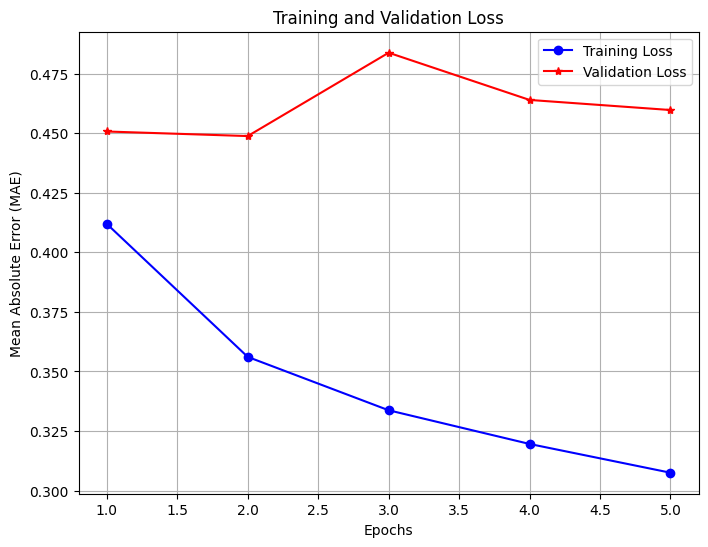

In [10]:
import matplotlib.pyplot as plt

# Extract the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()



This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. It is very 
effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to 
manipulate much longer sequences, we could either look at data from further back (by increasing the `lookback` parameter of the data 
generator), or look at high-resolution timeseries (by decreasing the `step` parameter of the generator). Here, we will chose (somewhat 
arbitrarily) to use a `step` twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one 
point per 30 minutes.

## Key Takeaways:

1. **Model Improvement**:
   - The model showed an improvement in the validation loss during the first two epochs. However, after that, the validation loss began to degrade, indicating potential overfitting or that the model had reached its capacity to improve further on the current training data.

2. **Early Stopping**:
   - The early stopping mechanism worked as intended, halting the training process after 5 epochs because there was no improvement in the validation loss for 3 consecutive epochs (from Epoch 3 onward).

3. **Best Model Saved**:
   - The model with the best performance on the validation set (Epoch 2) was saved, ensuring that the most optimal model is retained.

4. **Restoring Weights**:
   - By restoring the model to the best weights (from Epoch 2), the model avoids using suboptimal weights from later epochs where validation performance declined.

---

This process highlights the effectiveness of using early stopping and model checkpoints to prevent overfitting and save the best-performing model during training.


## Experiment with Step Size and GRU Model

In this experiment, the **step** parameter has been modified, and a **GRU (Gated Recurrent Unit)** model is being used for training. The following updates and rationale have been made:

### Updates in the Experiment:

1. **Step Size**:
   - The **step** parameter has been changed to **3**. This means that instead of sampling the data at every 6th time step (as in the previous experiments), the data will now be sampled at every 3rd time step. 
   - This change affects how much data is used in each time sequence, potentially capturing more granular patterns in the data, depending on the task.

2. **Data Generators**:
   - The **training**, **validation**, and **test** generators have been updated to reflect the new **step** size of 3. These generators will now use sequences sampled at every 3rd data point, which may allow the model to capture more detailed temporal dependencies.
   
   - The parameters for each generator are as follows:
     - **lookback**: 720 (unchanged)
     - **delay**: 144 (unchanged)
     - **step**: 3 (new value)

3. **Steps Calculation**:
   - The number of steps for the validation and test sets (`val_steps` and `test_steps`) is recalculated to account for the new **step** size and batch size (128).
   - `val_steps` and `test_steps` are used to define how many batches should be processed per epoch for the validation and test sets, respectively.

4. **GRU Model**:
   - You are experimenting with a GRU model, which is a type of Recurrent Neural Network (RNN). GRUs are designed to capture dependencies in sequential data and are more efficient than LSTMs (Long Short-Term Memory networks), especially for large sequences.
   - GRUs use gating mechanisms to control the flow of information through the network, helping it better learn temporal patterns in time-series data like the Jena Climate dataset.

---

In [12]:
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [20]:
# Check for NaN or Inf values in the data
np.isnan(float_data).any(), np.isinf(float_data).any()

# Try printing a small subset of the data to check the scaling
print(float_data[:10])


[[ 0.90014748 -1.93135845 -1.98211036 -1.86280029  1.07285236 -1.30742164
  -1.47375773 -0.79868641 -1.4762674  -1.47815522  2.12375056 -0.72950452
  -0.78067973 -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    -1.91582958  1.07883061 -1.32042698
  -1.4951961  -0.80075238 -1.49502455 -1.49932141  2.17199852 -0.93124017
  -0.88794488 -0.46317443]
 [ 0.90132666 -1.98671006 -2.03683914 -1.92001611  1.10872183 -1.32302805
  -1.49757814 -0.80281834 -1.49877598 -1.50167321  2.18235418 -1.27614304
  -1.26122763 -0.05330633]
 [ 0.89896829 -1.96411757 -2.01338395 -1.88652392  1.12665657 -1.31652538
  -1.4832859  -0.80488431 -1.48377026 -1.48756241  2.15764181 -1.17852902
  -1.31700551  0.25149699]
 [ 0.89896829 -1.95959907 -2.01003321 -1.8823374   1.12067832 -1.31522484
  -1.48090386 -0.80488431 -1.48377026 -1.48521061  2.15317004 -1.19154422
  -1.26122763  0.43968995]
 [ 0.89778911 -1.93474733 -1.98434419 -1.84605419  1.13861306 -1.30742164
  -1.46661161 -0.80488431 -1.46876453 -1.47109982  

## Model Overview

In this section, we define a Convolutional Neural Network (CNN) combined with **GRU (Gated Recurrent Unit)** layers for time-series forecasting on the Jena Climate dataset. This architecture is designed to capture both spatial and temporal dependencies in the datad and actual value# Chan explained in repoges from Previous Model:

- **Model Complexity**: The previous model used **32 filters** in the convolutional layers and had a simpler structure with fewer units in the GRU layers. The updated model increases the filter size to **64** and uses a more complex recurrent structure with two GRU layers to better capture complex patterns in the data.
- **Error Handling and Compatibility**: In the previous model, the `fit_generator` method was used, which has been deprecated in recent versions of Keras. The new model code uses `model.fit()`, which is the updated and recommended method for training in Keras.

### Purpose of the Model:

The purpose of this model is to predict climate conditions (such as temperature) based on historical data. The combination of convolutional layers for feature extraction and GRU layers for capturing long-term dependencies is expected to provide good results for forecasting future climate values. The model is trained on time-series data, with the GRU layers capturing the temporal patterns in the data, while the convolutional layers extract meaningful spatial features.

### Regularization:

To prevent overfitting, the GRU layers apply **dropout** (0.2) to the recurrent connections, and **dropout** in the first GRU layer is set to 0.3. This helps the model generalize better by preventing it from becoming too reliant on specific features of the training data.

### Model Summary:

- **Convolutional Layers**: Two Conv1D layers with 64 filters each and a MaxPooling1D layer to reduce dimensionality.
- **GRU Layers**: Two GRU layers to capture temporal dependencies, with dropout applied for regularization.
- **Output Layer**: A Dense layer with a single output unit for regression.
- **Optimizer**: RMSprop optimizer for efficient training.
- **Loss Function**: Mean Absolute Error (MAE) used as the loss function for regression tasks.


In [14]:
model = Sequential()
model.add(layers.Conv1D(64, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.GRU(64, return_sequences=True, dropout=0.3))
model.add(layers.GRU(32, dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, None, 64)       │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 64)       │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,489 (232.38 KB)

 Trainable params: 59,489 (232.38 KB)

 Non-trainable params: 0 (0.00 B)


## Training with Callbacks: Same as Before

This process is consistent with the previous approach, ensuring that we retain the best-performing model and avoid overfitting by utilizing early stopping and model checkpoints.

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',    
                               patience = 3,            
                               verbose = 1,      
                               restore_best_weights = True)  

# Model checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras',      
                              monitor='val_loss',  
                              save_best_only=True,  # Only save the best model
                              verbose=1)          

# Train the model with callbacks
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[early_stopping, checkpoint]  # Add the callbacks here
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4122
Epoch 1: val_loss improved from inf to 0.32070, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 64s 119ms/step - loss: 0.4121 - val_loss: 0.3207
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3312
Epoch 2: val_loss improved from 0.32070 to 0.31601, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - loss: 0.3312 - val_loss: 0.3160
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3061
Epoch 3: val_loss improved from 0.31601 to 0.30760, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - loss: 0.3061 - val_loss: 0.3076
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2950
Epoch 4: val_loss improved from 0.30760 to 0.30568, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 118ms/step - loss: 0.2950 - val_loss: 0.3057
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2804
Epoch 5: val

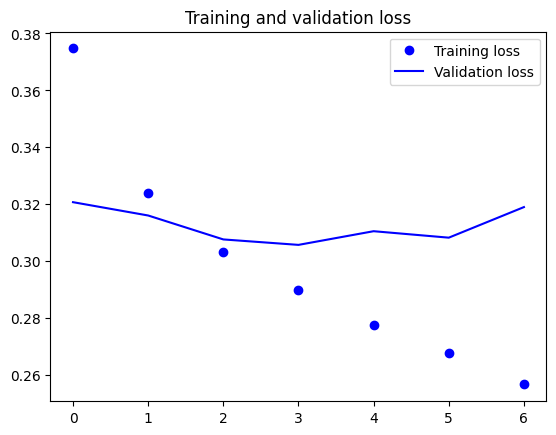

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

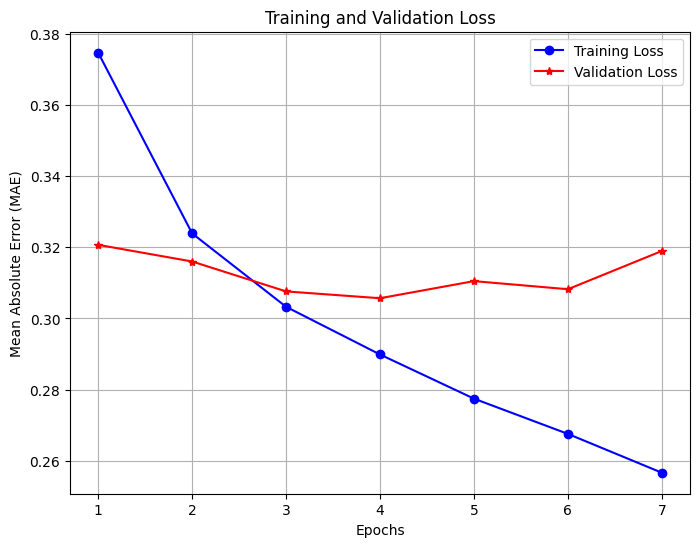

In [17]:
import matplotlib.pyplot as plt

# Extract the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


## Training Results and Insights

### Model Performance:
- **Epoch 1:** The model starts off with a validation loss of **0.3207**, significantly improving from the initial `inf` value, indicating that the training is beginning to make progress.
- **Epoch 2:** The validation loss improves further to **0.3160**, showing that the model continues to learn and generalize well.
- **Epoch 3:** The validation loss reaches **0.3076**, though it is a slight improvement from the previous epoch.
- **Epoch 4:** The validation loss improves again to **0.3057**, showcasing consistent improvements in both training and validation performance.
- **Epoch 5 - 6:** During these epochs, the validation loss starts to increase slightly, reaching **0.3105** in Epoch 5 and **0.3082** in Epoch 6, indicating potential overfitting or the model reaching its optimal point.
- **Epoch 7:** The validation loss increases further to **0.3190**, and since the performance does not improve, the **EarlyStopping** callback halts the training process.

### Key Takeaways:
1. **Early Stopping Effectiveness:** The **EarlyStopping** callback triggered after Epoch 7 due to no improvement in the validation loss for 3 consecutive epochs. This helps in preventing overfitting by stopping training at the right point.
2. **Model Improvement in Early Epochs:** The model demonstrated substantial improvement in the first few epochs, showing the effectiveness of the architecture in capturing patterns in the data.
3. **Overfitting Indication:** After Epoch 4, the validation loss started to plateau and even worsen, which is typical of overfitting. The model had already reached its best validation performance at Epoch 4.
4. **Restoration of Best Weights:** The model weights were restored to the best epoch (Epoch 4), ensuring that the model used for evaluation and deployment was the most optimal.

### Conclusion:
The model showed strong performance during the initial epochs, and the use of **EarlyStopping** and **ModelCheckpoint** helped to save the best model and prevent overfitting. The restoration of the best weights from Epoch 4 ensures the best possible performance for subsequent evaluations.
